# AFL Time Series Data Analysis with Result and AFL Fantasy Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chisquare, ttest_ind, zscore

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df = pd.read_csv("stats.csv")

df.head()

,Team,Player,D.O.B,Height,Weight,Position,Season,Round,Date,Score,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",1994-07-12,186,85,Midfield,2018,R1,2018-03-23,87.00,...,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",1986-11-26,174,74,Forward,2018,R1,2018-03-23,87.00,...,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",1992-09-22,181,81,Defender,2018,R1,2018-03-23,87.00,...,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",1995-04-21,182,80,Midfield,2018,R1,2018-03-23,87.00,...,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",1997-03-01,188,88,Defender,2018,R1,2018-03-23,87.00,...,0,0,8,14,0,0,9,1,0,93


In [3]:
df.dtypes

Team                       object
Player                     object
D.O.B                      object
Height                      int64
Weight                      int64
Position                   object
Season                      int64
Round                      object
Date                       object
Score                     float64
Margin                    float64
WinLoss                    object
Opposition                 object
Venue                      object
Disposals                   int64
Kicks                       int64
Marks                       int64
Handballs                   int64
Goals                       int64
Behinds                     int64
Hitouts                     int64
Tackles                     int64
Rebound50s                  int64
Inside50s                   int64
Clearances                  int64
Clangers                    int64
FreesFor                    int64
FreesAgainst                int64
BrownlowVotes               int64
ContendedPosse

### Creating Age column:

In [4]:
#Converting date objects to datetime:
df['D.O.B'] = pd.to_datetime(df['D.O.B'], format='%Y'+'-'+'%m'+'-'+'%d')
df['Date'] = pd.to_datetime(df['Date'], format='%Y'+'-'+'%m'+'-'+'%d')

#Creating Age column:
df.insert(2,'Age',(df['Date']-df['D.O.B'])/np.timedelta64(1,'Y'))

df.drop('D.O.B',axis=1,inplace=True)

### Fixing Null Values:

In [5]:
#Removing post season "Rounds" (they also have null values)
round_list = ['QF', 'SF', 'PF', 'GF', 'EF']
df = df[~df.Round.isin(round_list)]

df.head()

,Team,Player,Age,Height,Weight,Position,Season,Round,Date,Score,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",23.70,186,85,Midfield,2018,R1,2018-03-23,87.00,...,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",31.32,174,74,Forward,2018,R1,2018-03-23,87.00,...,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",25.50,181,81,Defender,2018,R1,2018-03-23,87.00,...,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",22.92,182,80,Midfield,2018,R1,2018-03-23,87.00,...,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",21.06,188,88,Defender,2018,R1,2018-03-23,87.00,...,0,0,8,14,0,0,9,1,0,93


In [6]:
#Checking nulls
df.isnull().sum()

Team                      0
Player                    0
Age                       0
Height                    0
Weight                    0
Position                  0
Season                    0
Round                     0
Date                      0
Score                     0
Margin                    0
WinLoss                   0
Opposition                0
Venue                     0
Disposals                 0
Kicks                     0
Marks                     0
Handballs                 0
Goals                     0
Behinds                   0
Hitouts                   0
Tackles                   0
Rebound50s                0
Inside50s                 0
Clearances                0
Clangers                  0
FreesFor                  0
FreesAgainst              0
BrownlowVotes             0
ContendedPossessions      0
UncontendedPossessions    0
ContestedMarks            0
MarksInside50             0
OnePercenters             0
Bounces                   0
GoalAssists         

### Creating a alphabetically sorted "Team, Opposition" column to be able to group by game:

In [7]:
df['Teams'] = df[['Team','Opposition']].values.tolist()

In [8]:
df.Teams = df.Teams.apply(sorted).apply(', '.join)

### Creating Points Per Percent Played column:

In [9]:
#Creating "points per percent of game played" columns
df.insert(10, 'PointsPerPercentPlayed',(df['Goals']+df['Behinds'])/df['PercentPlayed'])

## Feature info:

In [10]:
df.describe()

,Age,Height,Weight,Season,Score,PointsPerPercentPlayed,Margin,Disposals,Kicks,Marks,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
count,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,...,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00
mean,24.96,187.76,88.07,2015.00,88.53,0.01,0.00,16.73,9.43,4.08,...,0.84,0.14,6.40,10.28,0.49,0.53,2.15,0.38,0.40,81.81
std,3.68,7.20,8.08,2.00,27.81,0.02,46.17,7.21,4.56,2.55,...,0.98,0.55,3.71,5.31,0.85,0.99,2.33,0.93,0.68,13.32
min,18.27,167.00,67.00,2012.00,17.00,0.00,-162.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,22.07,183.00,82.00,2013.00,69.00,0.00,-30.00,11.00,6.00,2.00,...,0.00,0.00,4.00,6.00,0.00,0.00,1.00,0.00,0.00,79.00
50%,24.61,187.00,86.00,2015.00,86.00,0.00,0.00,16.00,9.00,4.00,...,1.00,0.00,6.00,10.00,0.00,0.00,1.00,0.00,0.00,84.00
75%,27.49,193.00,93.00,2017.00,106.00,0.02,30.00,21.00,12.00,6.00,...,1.00,0.00,8.00,14.00,1.00,1.00,3.00,0.00,1.00,89.00
max,41.26,211.00,118.00,2018.00,193.00,0.25,162.00,54.00,36.00,21.00,...,8.00,3.00,32.00,40.00,8.00,13.00,25.00,15.00,6.00,100.00


In [11]:
number_list = df.select_dtypes(include=['number']).columns

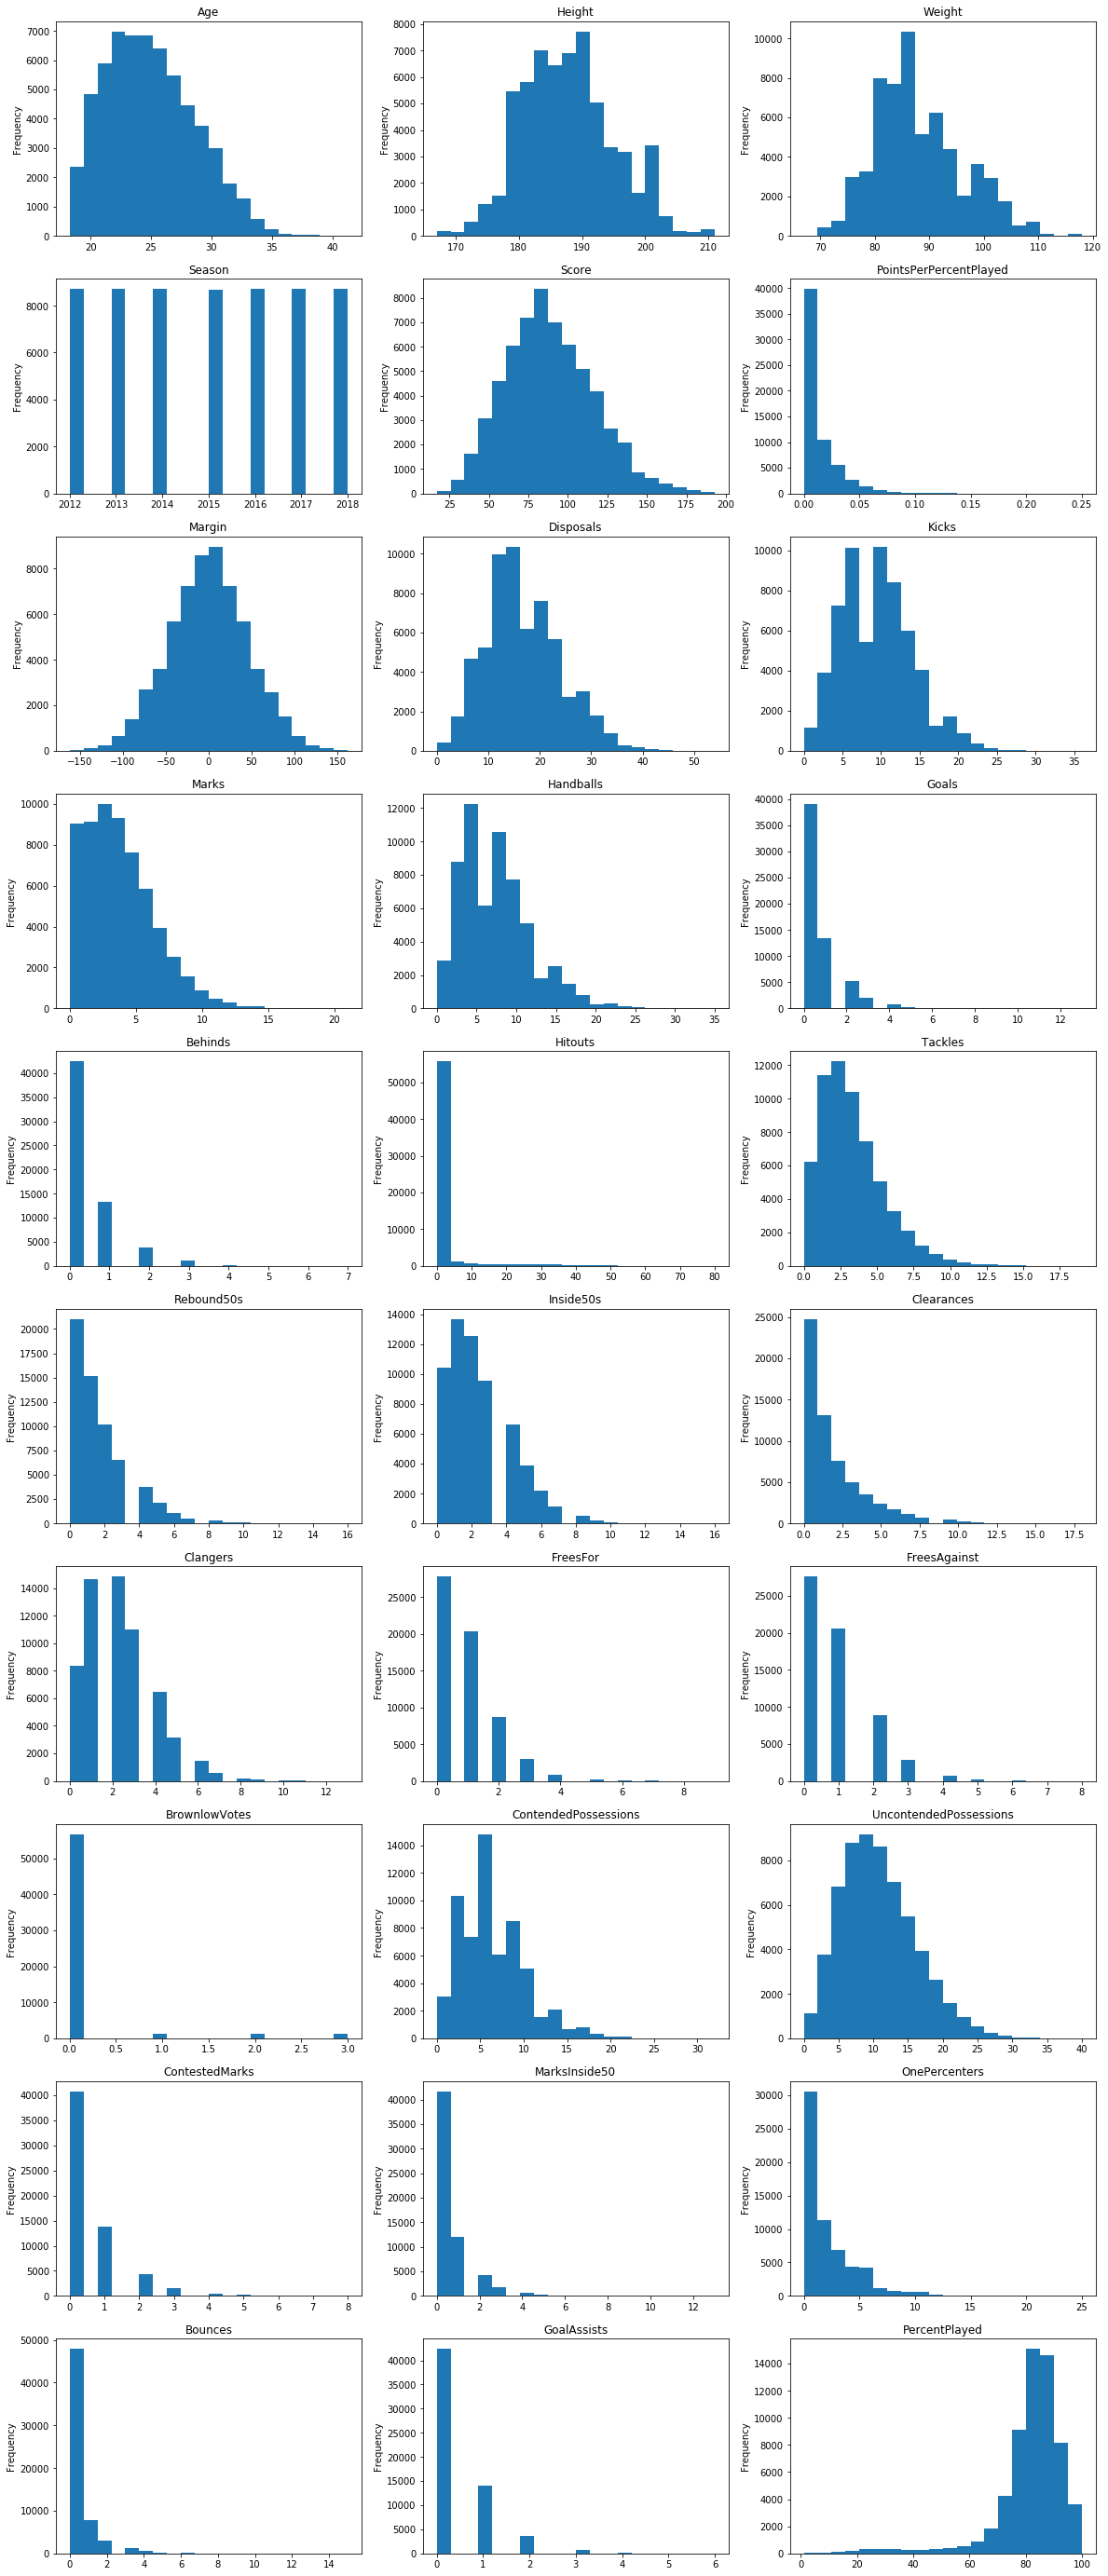

In [12]:
fig,ax = plt.subplots(10, 3)

m=0
for i in range(10):
    for j in range(3):

        df[number_list[m]].plot(kind='hist',bins=20,ax=ax[i,j],figsize=(20, 50)).set_title(number_list[m])
        m+=1

## Normalizing by game:

In [13]:
df_ML = df.set_index(['Season','Round']).sort_index()
df_ML

Team                Player   Age  Height  Weight  \
Season Round                                                                 
2012   R1             Adelaide         Callinan, Ian 29.28     172      74   
       R1             Adelaide  Dangerfield, Patrick 21.99     189      92   
       R1             Adelaide      Doughty, Michael 32.66     177      81   
       R1             Adelaide      Douglas, Richard 25.15     181      79   
       R1             Adelaide      Henderson, Ricky 23.55     188      91   
       R1             Adelaide           Jacobs, Sam 23.97     200     102   
       R1             Adelaide      Johncock, Graham 29.44     178      86   
       R1             Adelaide          Lynch, Tom T 21.54     193      88   
       R1             Adelaide         Mackay, David 23.68     181      77   
       R1             Adelaide           Otten, Andy 22.88     192      94   
       R1             Adelaide       Petrenko, Jared 22.27     178      81   
       R1             Adelaide      Porplyzia, Jason 27.34     177      85   
       R1             Adelaide         Reilly, Brent 28.38     183      85   
       R1             Adelaide           Rutten, Ben 28.84     190      98   
       R1             Adelaide          Sloane, Rory 22.04     182      83   
       R1             Adelaide         Smith, Brodie 20.21     189      90   
       R1             Adelaide         Talia, Daniel 20.50     197      98   
       R1             Adelaide       Thompson, Scott 29.05     185      86   
       R1             Adelaide         Tippett, Kurt 24.90     202     106   
       R1             Adelaide         Vince, Bernie 26.49     186      86   
       R1             Adelaide        Walker, Taylor 21.93     193     102   
       R1             Adelaide     van Berlo, Nathan 25.82     184      83   
       R1       Brisbane Lions           Adcock, Jed 26.37     183      84   
       R1       Brisbane Lions        Banfield, Todd 21.76     183      83   
       R1       Brisbane Lions          Beams, Claye 20.58     183      82   
       R1       Brisbane Lions         Bewick, Rohan 22.47     185      83   
       R1       Brisbane Lions          Black, Simon 32.99     185      81   
       R1       Brisbane Lions          Golby, Mitch 20.49     184      84   
       R1       Brisbane Lions        Hanley, Pearce 23.37     185      85   
       R1       Brisbane Lions           Hudson, Ben 33.10     199     106   
...                        ...                   ...   ...     ...     ...   
2018   R9           West Coast      McGovern, Jeremy 26.09     196      99   
       R9           West Coast         Naitanui, Nic 28.04     201     110   
       R9           West Coast          Redden, Jack 27.44     190      85   
       R9           West Coast         Rioli, Willie 22.96     175      80   
       R9           West Coast            Sheed, Dom 23.11     185      87   
       R9           West Coast        Sheppard, Brad 26.99     187      85   
       R9           West Coast        Waterman, Jake 20.04     191      92   
       R9           West Coast           Yeo, Elliot 24.63     190      89   
       R9     Western Bulldogs   Bontempelli, Marcus 22.48     193      93   
       R9     Western Bulldogs             Boyd, Tom 22.74     200     103   
       R9     Western Bulldogs          Cordy, Zaine 21.56     193      90   
       R9     Western Bulldogs       Crozier, Hayden 24.40     185      79   
       R9     Western Bulldogs        Dahlhaus, Luke 25.74     179      77   
       R9     Western Bulldogs          Dale, Bailey 21.82     183      82   
       R9     Western Bulldogs         Daniel, Caleb 21.86     168      72   
       R9     Western Bulldogs         Dunkley, Josh 21.35     190      88   
       R9     Western Bulldogs         Gowers, Billy 21.94     187      87   
       R9     Western Bulldogs        Hunter, Lachie 23.43     183      82   
       R9     Western Bulldogs     Johannisen, J

In [14]:
scaling_list = ['PointsPerPercentPlayed','Disposals', 'Kicks', 'Marks','Handballs',
                'Goals', 'Behinds','Hitouts', 'Tackles', 'Rebound50s','Inside50s',
                'Clearances','Clangers', 'FreesFor', 'FreesAgainst','BrownlowVotes',
                'ContendedPossessions', 'UncontendedPossessions','ContestedMarks',
                'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists']

In [15]:
normalize_list = ['Age', 'Height', 'Weight', 'Score', 'Margin']

In [16]:
for col in scaling_list:
    df_ML[col] = df_ML.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [17]:
for col in normalize_list:
    df_ML[col] = df_ML.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))

# Comparing points made per percent of game to various characteristics:

In [18]:
print(df.Position.value_counts())

hist_names = df.Position.value_counts().index.drop('Midfield, Ruck')

Defender              20950
Forward               15047
Midfield              14970
Midfield, Forward      4216
Ruck                   3111
Forward, Ruck          1099
Defender, Midfield      775
Defender, Forward       771
Midfield, Ruck            1
Name: Position, dtype: int64


## Age:
### Actual Points:

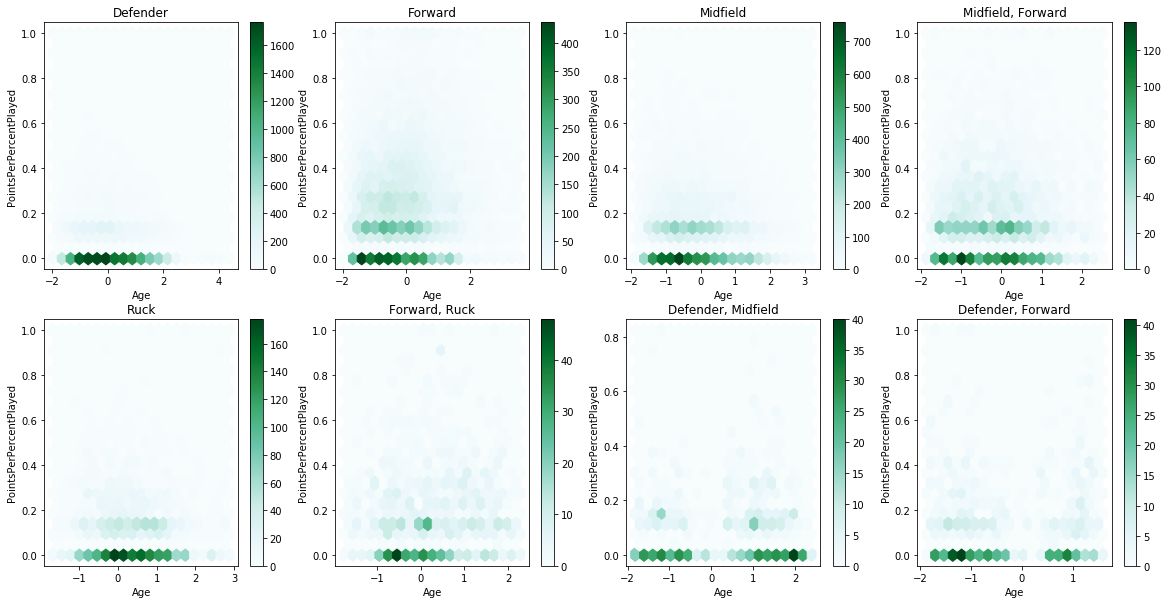

In [19]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Age','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Height:
### Actual Points:

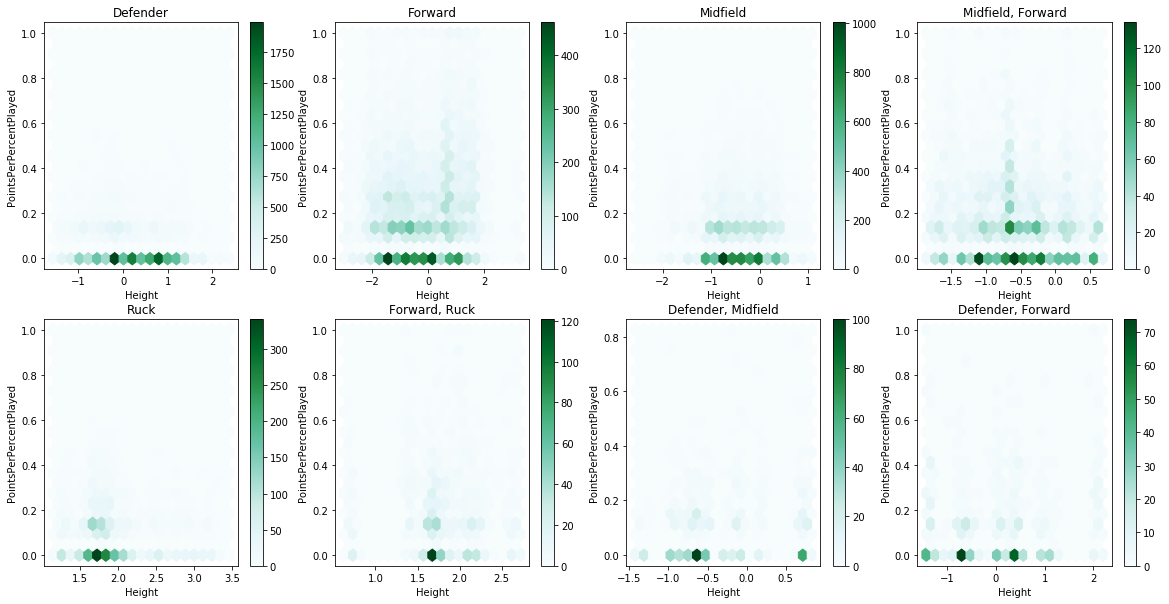

In [20]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Height','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Weight:
### Actual Points:

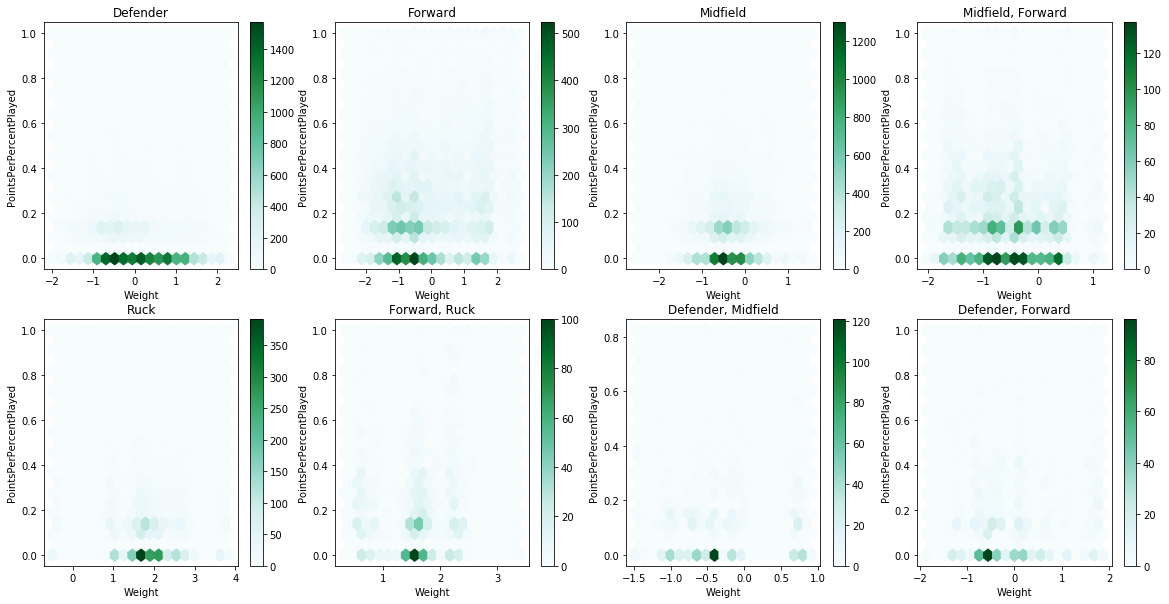

In [21]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Weight','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

In [22]:
df_ML = df_ML.set_index(['Teams'],append=1).sort_index()
df_ML

Team                Player   Age  \
Season Round Teams                                                          
2012   R1    Adelaide, Gold Coast    Adelaide         Callinan, Ian  1.29   
             Adelaide, Gold Coast    Adelaide  Dangerfield, Patrick -0.68   
             Adelaide, Gold Coast    Adelaide      Doughty, Michael  2.20   
             Adelaide, Gold Coast    Adelaide      Douglas, Richard  0.17   
             Adelaide, Gold Coast    Adelaide      Henderson, Ricky -0.26   
             Adelaide, Gold Coast    Adelaide           Jacobs, Sam -0.14   
             Adelaide, Gold Coast    Adelaide      Johncock, Graham  1.34   
             Adelaide, Gold Coast    Adelaide          Lynch, Tom T -0.80   
             Adelaide, Gold Coast    Adelaide         Mackay, David -0.22   
             Adelaide, Gold Coast    Adelaide           Otten, Andy -0.44   
             Adelaide, Gold Coast    Adelaide       Petrenko, Jared -0.60   
             Adelaide, Gold Coast    Adelaide      Porplyzia, Jason  0.77   
             Adelaide, Gold Coast    Adelaide         Reilly, Brent  1.05   
             Adelaide, Gold Coast    Adelaide           Rutten, Ben  1.17   
             Adelaide, Gold Coast    Adelaide          Sloane, Rory -0.67   
             Adelaide, Gold Coast    Adelaide         Smith, Brodie -1.16   
             Adelaide, Gold Coast    Adelaide         Talia, Daniel -1.09   
             Adelaide, Gold Coast    Adelaide       Thompson, Scott  1.23   
             Adelaide, Gold Coast    Adelaide         Tippett, Kurt  0.11   
             Adelaide, Gold Coast    Adelaide         Vince, Bernie  0.54   
             Adelaide, Gold Coast    Adelaide        Walker, Taylor -0.70   
             Adelaide, Gold Coast    Adelaide     van Berlo, Nathan  0.35   
             Adelaide, Gold Coast  Gold Coast          Ablett, Gary  0.91   
             Adelaide, Gold Coast  Gold Coast       Bennell, Harley -1.36   
             Adelaide, Gold Coast  Gold Coast        Brennan, Jared  0.86   
             Adelaide, Gold Coast  Gold Coast       Brown, Campbell  1.11   
             Adelaide, Gold Coast  Gold Coast           Caddy, Josh -1.35   
             Adelaide, Gold Coast  Gold Coast      Gorringe, Daniel -1.27   
             Adelaide, Gold Coast  Gold Coast           Hall, Aaron -0.84   
             Adelaide, Gold Coast  Gold Coast       Harbrow, Jarrod -0.22   
...                                       ...                   ...   ...   
2018   R9    Richmond, West Coast    Richmond        Martin, Dustin  0.44   
             Richmond, West Coast    Richmond      McIntosh, Kamdyn -0.28   
             Richmond, West Coast    Richmond       Nankervis, Toby -0.37   
             Richmond, West Coast    Richmond           Rance, Alex  0.88   
             Richmond, West Coast    Richmond        Riewoldt, Jack  1.13   
             Richmond, West Coast    Richmond         Short, Jayden -0.75   
             Richmond, West Coast    Richmond       Townsend, Jacob -0.08   
             Richmond, West Coast    Richmond        Vlastuin, Nick -0.29   
             Richmond, West Coast  West Coast      Ah Chee, Brendon -0.21   
             Richmond, West Coast  West Coast          Barrass, Tom -0.67   
             Richmond, West Coast  West Coast             Cole, Tom -1.10   
             Richmond, West Coast  West Coast         Cripps, Jamie  0.23   
             Richmond, West Coast  West Coast         Darling, Jack  0.19   
             Richmond, West Coast  West Coast          Duggan, Liam -0.98   
             Richmond, West Coast  West Coast          Gaff, Andrew  0.19   
             Richmond, West Coast  West Coast         Hurn, Shannon  1.43   
             Richmond, West Coast  West Coast       Hutchings, Mark  0.46   
             Richmond, West Coast  West Coast          Jetta, Lewis  1.00   
             Richmond, West Coast  West Coast       Kennedy, Josh J  1.44   
             Richmond, West Coast  We

In [23]:
for col in scaling_list:
    df_ML[col] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [24]:
for col in normalize_list:
    df_ML[col] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))

C:\Users\Aaron\Anaconda3\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [25]:
df_ML.fillna(0,inplace=True)

df_ML.isnull().sum()

Team                      0
Player                    0
Age                       0
Height                    0
Weight                    0
Position                  0
Date                      0
Score                     0
PointsPerPercentPlayed    0
Margin                    0
WinLoss                   0
Opposition                0
Venue                     0
Disposals                 0
Kicks                     0
Marks                     0
Handballs                 0
Goals                     0
Behinds                   0
Hitouts                   0
Tackles                   0
Rebound50s                0
Inside50s                 0
Clearances                0
Clangers                  0
FreesFor                  0
FreesAgainst              0
BrownlowVotes             0
ContendedPossessions      0
UncontendedPossessions    0
ContestedMarks            0
MarksInside50             0
OnePercenters             0
Bounces                   0
GoalAssists               0
PercentPlayed       

In [26]:
df_ML.WinLoss.replace(['W', 'L', 'D'],[1,0,.5],inplace=True)

In [27]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Season','Round'],axis=1,inplace=True)

df_ML.set_index(['Date','Teams','Team'],inplace=True)
df_ML.sort_index(inplace=True)
df_ML

Player  \
Date       Teams                          Team                                           
2012-03-24 Greater Western Sydney, Sydney Greater Western Sydney           Bugg, Tomas   
                                          Greater Western Sydney       Cameron, Jeremy   
                                          Greater Western Sydney     Coniglio, Stephen   
                                          Greater Western Sydney          Cornes, Chad   
                                          Greater Western Sydney           Davis, Phil   
                                          Greater Western Sydney         Folau, Israel   
                                          Greater Western Sydney       Giles, Jonathan   
                                          Greater Western Sydney          Greene, Toby   
                                          Greater Western Sydney       Hampton, Curtly   
                                          Greater Western Sydney         Hombsch, Jack   
                                          Greater Western Sydney  Hoskin-Elliott, Will   
                                          Greater Western Sydney         Kennedy, Adam   
                                          Greater Western Sydney       McDonald, James   
                                          Greater Western Sydney             Mohr, Tim   
                                          Greater Western Sydney          Palmer, Rhys   
                                          Greater Western Sydney          Shiel, Dylan   
                                          Greater Western Sydney          Smith, Devon   
                                          Greater Western Sydney       Tomlinson, Adam   
                                          Greater Western Sydney       Townsend, Jacob   
                                          Greater Western Sydney            Tyson, Dom   
                                          Greater Western Sydney          Ward, Callan   
                                          Greater Western Sydney        Wilson, Nathan   
                                          Sydney                           Bird, Craig   
                                          Sydney                          Bolton, Jude   
                                          Sydney                     Cunningham, Harry   
                                          Sydney                      Everitt, Andrejs   
                                          Sydney                          Goodes, Adam   
                                          Sydney                         Grundy, Heath   
                                          Sydney                        Hannebery, Dan   
                                          Sydney                          Jack, Kieren   
...                                                                                ...   
2018-08-26 North Melbourne, St Kilda      North Melbourne              Tarrant, Robbie   
                                          North Melbourne            Thompson, Scott D   
                                          North Melbourne                Turner, Kayne   
                                          North Melbourne                Waite, Jarrad   
                                          North Melbourne             Williams, Marley   
                                          North Melbourne                  Wood, Mason   
                                          North Melbourne                  Wright, Sam   
                                          North Melbourne                Ziebell, Jack   
                                          St Kilda                        Acres, Blake   
                                          St Kilda                     Armitage, David   
                                          St Kilda                       Austin, Logan   
                                          St Kilda                      Billings, Jack   
                              

# Comparing points made per percent of game to various characteristics:

In [28]:
print(df.Position.value_counts())

hist_names = df.Position.value_counts().index.drop('Midfield, Ruck')

Defender              20950
Forward               15047
Midfield              14970
Midfield, Forward      4216
Ruck                   3111
Forward, Ruck          1099
Defender, Midfield      775
Defender, Forward       771
Midfield, Ruck            1
Name: Position, dtype: int64


## Age:
### Actual Points:

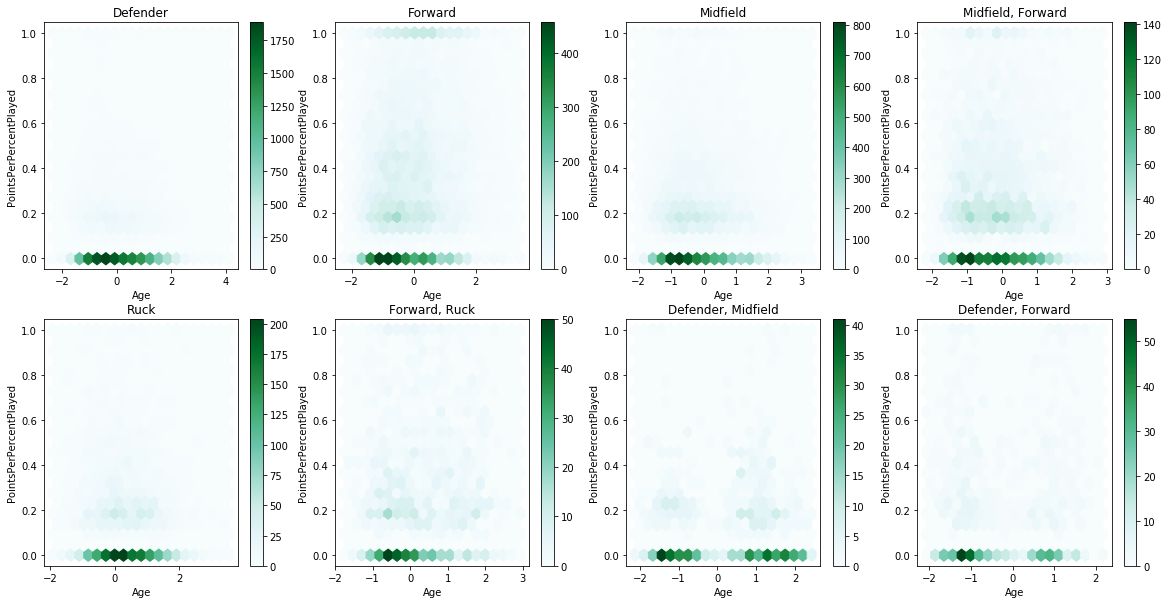

In [29]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Age','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Height:
### Actual Points:

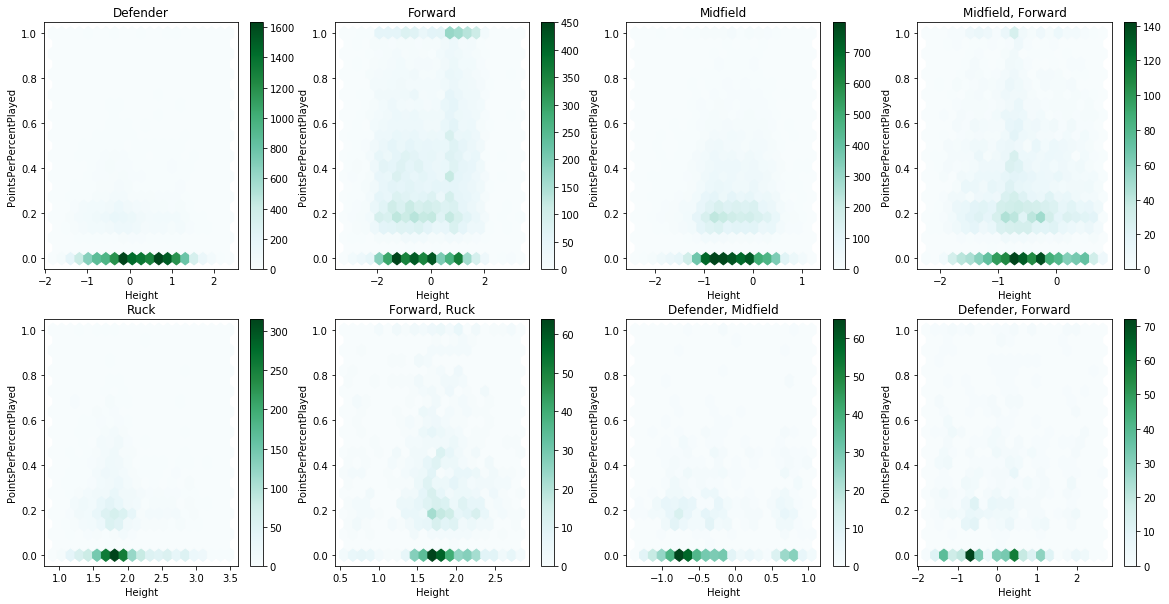

In [30]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Height','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Weight:
### Actual Points:

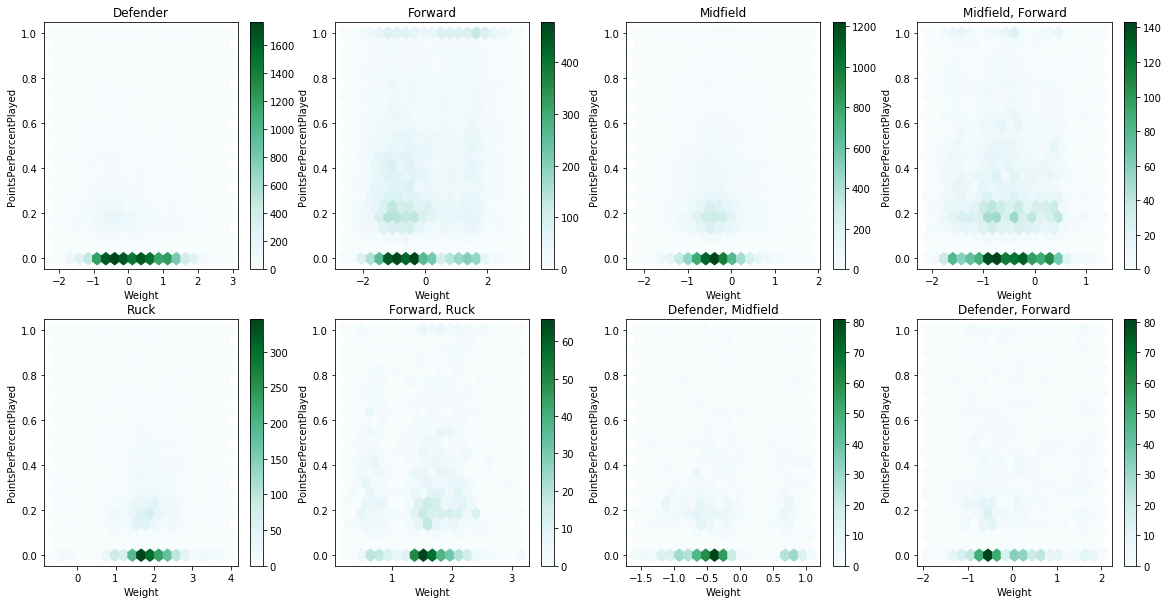

In [31]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Weight','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

In [32]:
number_list = scaling_list+normalize_list
number_list

['PointsPerPercentPlayed',
 'Disposals',
 'Kicks',
 'Marks',
 'Handballs',
 'Goals',
 'Behinds',
 'Hitouts',
 'Tackles',
 'Rebound50s',
 'Inside50s',
 'Clearances',
 'Clangers',
 'FreesFor',
 'FreesAgainst',
 'BrownlowVotes',
 'ContendedPossessions',
 'UncontendedPossessions',
 'ContestedMarks',
 'MarksInside50',
 'OnePercenters',
 'Bounces',
 'GoalAssists',
 'Age',
 'Height',
 'Weight',
 'Score',
 'Margin']

In [33]:
df_ML[number_list] = df_ML[number_list].multiply(df_ML.PercentPlayed/100,axis=0)

In [34]:
df_ML[number_list]

PointsPerPercentPlayed  \
Date       Teams                          Team                                             
2012-03-24 Greater Western Sydney, Sydney Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.20   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.61   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.20   
                                          Greater Western Sydney                    0.20   
                                          Greater Western Sydney                    0.20   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.41   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.00   
                                          Greater Western Sydney                    0.20   
                                          Greater Western Sydney                    0.20   
                                          Sydney                                    0.81   
                                          Sydney                                    0.20   
                                          Sydney                                    0.00   
                                          Sydney                                    0.61   
                                          Sydney                                    0.20   
                                          Sydney                                    0.00   
                                          Sydney                                    0.00   
                                          Sydney                                    0.41   
...                                                                                  ...   
2018-08-26 North Melbourne, St Kilda      North Melbourne                           0.00   
                                          North Melbourne                           0.00   
                                          North Melbourne                           0.00   
                                          North Melbourne                           0.85   
                                          North Melbourne                           0.00   
                                          North Melbourne                           0.14   
                                          North Melbourne                           0.00   
                                          North Melbourne                           0.57   
                                          St Kilda                                  0.00   
                                          St Kilda                                  0.00   
                                          St Kilda                                  0.00   
                  

In [35]:
df_ML[number_list] = df_ML[number_list].groupby(['Date','Teams','Team']).mean()

In [36]:
df_ML.drop(['Player','Position','PercentPlayed'],axis=1,inplace=True)

In [37]:
df_ML.drop_duplicates(inplace=True)

## Offsetting columns for time series analysis:

In [38]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Teams'],axis=1,inplace=True)

df_ML

,Date,Team,Age,Height,Weight,Score,PointsPerPercentPlayed,Margin,WinLoss,Opposition,...,FreesFor,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists
0,2012-03-24,Greater Western Sydney,-0.28,0.09,0.03,-0.81,0.10,-0.81,0.00,Sydney,...,0.23,0.20,0.00,0.31,0.40,0.16,0.12,0.28,0.06,0.06
1,2012-03-24,Sydney,0.39,0.02,0.10,0.81,0.24,0.81,1.00,Greater Western Sydney,...,0.15,0.30,0.07,0.37,0.42,0.22,0.12,0.23,0.09,0.18
2,2012-03-29,Carlton,0.16,-0.01,-0.00,0.81,0.14,0.81,1.00,Richmond,...,0.19,0.21,0.08,0.31,0.39,0.17,0.16,0.25,0.11,0.14
3,2012-03-29,Richmond,-0.14,0.05,0.03,-0.81,0.09,-0.81,0.00,Carlton,...,0.21,0.18,0.00,0.27,0.28,0.08,0.10,0.16,0.08,0.07
4,2012-03-30,Collingwood,-0.14,0.04,0.16,-0.81,0.17,-0.81,0.00,Hawthorn,...,0.23,0.22,0.00,0.28,0.26,0.11,0.14,0.11,0.12,0.14
5,2012-03-30,Hawthorn,0.27,-0.03,-0.09,0.81,0.18,0.81,1.00,Collingwood,...,0.15,0.28,0.08,0.26,0.34,0.06,0.12,0.20,0.09,0.17
6,2012-03-31,Adelaide,0.30,-0.10,0.00,0.81,0.21,0.81,1.00,Gold Coast,...,0.27,0.31,0.04,0.34,0.30,0.13,0.20,0.21,0.01,0.18
7,2012-03-31,Gold Coast,-0.23,0.11,0.03,-0.81,0.08,-0.81,0.00,Adelaide,...,0.30,0.30,0.04,0.29,0.25,0.13,0.11,0.30,0.10,0.12
8,2012-03-31,Brisbane Lions,0.02,0.05,0.10,0.81,0.15,0.81,1.00,Melbourne,...,0.18,0.23,0.05,0.31,0.40,0.10,0.09,0.25,0.13,0.12
9,2012-03-31,Melbourne,0.03,0.02,-0.00,-0.81,0.10,-0.81,0.00,Brisbane Lions,...,0.21,0.18,0.02,0.31,0.20,0.10,0.03,0.12,0.16,0.06


In [39]:
Offset_List = ['Score','PointsPerPercentPlayed','Margin','WinLoss','Disposals',
               'Kicks','Marks','Handballs', 'Goals','Behinds','Hitouts','Tackles',
               'Rebound50s', 'Inside50s', 'Clearances','Clangers','FreesFor',
               'FreesAgainst', 'BrownlowVotes','ContendedPossessions', 
               'UncontendedPossessions', 'ContestedMarks','MarksInside50',
               'OnePercenters', 'Bounces', 'GoalAssists']

In [40]:
PointsList=[]

for column_name in Offset_List:
    df_ML[column_name+'1'] = df_ML.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Team')[column_name].shift().reset_index(['Date'], drop=1)

    PointsList.append(column_name+'1')

    for i in range(2,7):
        df_ML[column_name+str(i)] = df_ML.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Team')[column_name].rolling(window=i,min_periods=i).mean()\
            .groupby('Team').shift().reset_index(['Team','Date'], drop=1)

        PointsList.append(column_name+str(i))

In [41]:
Offset_List.remove('WinLoss')

df_ML.drop(Offset_List,axis=1,inplace=True)

In [43]:
#Fixing nulls again because of shifting:
df_ML.fillna(0,inplace=True)

df_ML.isnull().sum()

Date                       0
Team                       0
Age                        0
Height                     0
Weight                     0
WinLoss                    0
Opposition                 0
Venue                      0
Score1                     0
Score2                     0
Score3                     0
Score4                     0
Score5                     0
Score6                     0
PointsPerPercentPlayed1    0
PointsPerPercentPlayed2    0
PointsPerPercentPlayed3    0
PointsPerPercentPlayed4    0
PointsPerPercentPlayed5    0
PointsPerPercentPlayed6    0
Margin1                    0
Margin2                    0
Margin3                    0
Margin4                    0
Margin5                    0
Margin6                    0
WinLoss1                   0
WinLoss2                   0
WinLoss3                   0
WinLoss4                   0
                          ..
ContestedMarks1            0
ContestedMarks2            0
ContestedMarks3            0
ContestedMarks

In [44]:
df_ML.set_index(['Team','Date']).sort_index().head()

Age  Height  Weight  WinLoss              Opposition  \
Team     Date                                                               
Adelaide 2012-03-31 0.30   -0.10    0.00     1.00              Gold Coast   
         2012-04-07 0.01   -0.05    0.12     1.00        Western Bulldogs   
         2012-04-15 0.04   -0.05    0.02     0.00                Hawthorn   
         2012-04-21 0.16    0.03    0.11     1.00  Greater Western Sydney   
         2012-04-29 0.07   -0.05    0.06     1.00           Port Adelaide   

                             Venue  Score1  Score2  Score3  Score4  ...  \
Team     Date                                                       ...   
Adelaide 2012-03-31        Carrara    0.00    0.00    0.00    0.00  ...   
         2012-04-07  Football Park    0.81    0.00    0.00    0.00  ...   
         2012-04-15         M.C.G.    0.81    0.81    0.00    0.00  ...   
         2012-04-21  Football Park   -0.81    0.00    0.27    0.00  ...   
         2012-04-29  Football Park    0.81    0.00    0.27    0.40  ...   

                     Bounces3  Bounces4  Bounces5  Bounces6  GoalAssists1  \
Team     Date                                                               
Adelaide 2012-03-31      0.00      0.00      0.00      0.00          0.00   
         2012-04-07      0.00      0.00      0.00      0.00          0.18   
         2012-04-15      0.00      0.00      0.00      0.00          0.08   
         2012-04-21      0.04      0.00      0.00      0.00          0.12   
         2012-04-29      0.05      0.04      0.00      0.00          0.20   

                     GoalAssists2  GoalAssists3  GoalAssists4  GoalAssists5  \
Team     Date                                                                 
Adelaide 2012-03-31          0.00          0.00          0.00          0.00   
         2012-04-07          0.00          0.00          0.00          0.00   
         2012-04-15          0.13          0.00          0.00          0.00   
         2012-04-21          0.10          0.13          0.00          0.00   
         2012-04-29          0.16          0.13          0.14          0.00   

                     GoalAssists6  
Team     Date                      
Adelaide 2012-03-31          0.00  
         2012-04-07          0.00  
         2012-04-15          0.00  
         2012-04-21          0.00  
         2012-04-29          0.00  

[5 rows x 162 columns]

# Machine Learning:
## Making dummy variables:

In [45]:
df_ML.select_dtypes(include=['object'])

,Team,Opposition,Venue
0,Greater Western Sydney,Sydney,Stadium Australia
1,Sydney,Greater Western Sydney,Stadium Australia
2,Carlton,Richmond,M.C.G.
3,Richmond,Carlton,M.C.G.
4,Collingwood,Hawthorn,M.C.G.
5,Hawthorn,Collingwood,M.C.G.
6,Adelaide,Gold Coast,Carrara
7,Gold Coast,Adelaide,Carrara
8,Brisbane Lions,Melbourne,M.C.G.
9,Melbourne,Brisbane Lions,M.C.G.


In [46]:
categorical_list = df_ML.select_dtypes(include=['object']).columns

In [47]:
df_ML = pd.get_dummies(df_ML,columns=categorical_list,drop_first=True)

In [48]:
for col in df_ML:
    print(col)

Date
Age
Height
Weight
WinLoss
Score1
Score2
Score3
Score4
Score5
Score6
PointsPerPercentPlayed1
PointsPerPercentPlayed2
PointsPerPercentPlayed3
PointsPerPercentPlayed4
PointsPerPercentPlayed5
PointsPerPercentPlayed6
Margin1
Margin2
Margin3
Margin4
Margin5
Margin6
WinLoss1
WinLoss2
WinLoss3
WinLoss4
WinLoss5
WinLoss6
Disposals1
Disposals2
Disposals3
Disposals4
Disposals5
Disposals6
Kicks1
Kicks2
Kicks3
Kicks4
Kicks5
Kicks6
Marks1
Marks2
Marks3
Marks4
Marks5
Marks6
Handballs1
Handballs2
Handballs3
Handballs4
Handballs5
Handballs6
Goals1
Goals2
Goals3
Goals4
Goals5
Goals6
Behinds1
Behinds2
Behinds3
Behinds4
Behinds5
Behinds6
Hitouts1
Hitouts2
Hitouts3
Hitouts4
Hitouts5
Hitouts6
Tackles1
Tackles2
Tackles3
Tackles4
Tackles5
Tackles6
Rebound50s1
Rebound50s2
Rebound50s3
Rebound50s4
Rebound50s5
Rebound50s6
Inside50s1
Inside50s2
Inside50s3
Inside50s4
Inside50s5
Inside50s6
Clearances1
Clearances2
Clearances3
Clearances4
Clearances5
Clearances6
Clangers1
Clangers2
Clangers3
Clangers4
Clangers5
C

In [49]:
df_ML=df_ML[df_ML.WinLoss!=.5]

In [50]:
df_ML.dtypes

Date                           datetime64[ns]
Age                                   float64
Height                                float64
Weight                                float64
WinLoss                               float64
Score1                                float64
Score2                                float64
Score3                                float64
Score4                                float64
Score5                                float64
Score6                                float64
PointsPerPercentPlayed1               float64
PointsPerPercentPlayed2               float64
PointsPerPercentPlayed3               float64
PointsPerPercentPlayed4               float64
PointsPerPercentPlayed5               float64
PointsPerPercentPlayed6               float64
Margin1                               float64
Margin2                               float64
Margin3                               float64
Margin4                               float64
Margin5                           

## Spliting Data and Creating Model:

In [51]:
X = df_ML.drop(['WinLoss','Date'],axis=1)
y = df_ML['WinLoss']

In [52]:
#classifiers
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

#for function below
from sklearn.model_selection import StratifiedKFold
from time import time
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score,\
    precision_score,recall_score,f1_score,roc_auc_score,matthews_corrcoef

In [53]:
def metrics_function(target,pred):
    return accuracy_score(target, pred),precision_score(target, pred),\
        recall_score(target, pred),f1_score(target, pred),\
        roc_auc_score(target, pred),matthews_corrcoef(target, pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=StratifiedKFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    acc_list_train=[]
    acc_list_test=[]
    prc_list_train=[]
    prc_list_test=[]
    rcal_list_train=[]
    rcal_list_test=[]
    f1_list_train=[]
    f1_list_test=[]
    matt_list_train=[]
    matt_list_test=[]
    AUC_list_train=[]
    AUC_list_test=[]
    
    samp_size=X_all.shape[0]//row_factor
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_acc,train_prc,train_rcal,train_f1,train_auc,train_matt=metrics_function(y_train,y_pred1)
        
        test_acc,test_prc,test_rcal,test_f1,test_auc,test_matt=metrics_function(y_test,y_pred2)
        
        acc_list_train.append(train_acc)
        acc_list_test.append(test_acc)
        prc_list_train.append(train_prc)
        prc_list_test.append(test_prc)
        rcal_list_train.append(train_rcal)
        rcal_list_test.append(test_rcal)
        
        f1_list_train.append(train_f1)
        f1_list_test.append(test_f1)
        matt_list_train.append(train_matt)
        matt_list_test.append(test_matt)
        AUC_list_train.append(train_auc)
        AUC_list_test.append(test_auc)
    
    print("Averages:"'\n')
    
    print("Train acc: {}, Test acc: {}".format(np.mean(acc_list_train),
                                               np.mean(acc_list_test)))
    print("Train prc: {}, Test prc: {}".format(np.mean(prc_list_train),
                                               np.mean(prc_list_test)))
    print("Train recall: {}, Test recall: {}".format(np.mean(rcal_list_train),
                                                     np.mean(rcal_list_test)),'\n')
    
    print("Train f1: {}, Test f1: {}".format(np.mean(f1_list_train),
                                             np.mean(f1_list_test)))
    print("Train MattCC: {}, Test MattCC: {}".format(np.mean(matt_list_train),
                                                     np.mean(matt_list_test)))
    print("Train AUC: {}, Test AUC: {}".format(np.mean(AUC_list_train),
                                               np.mean(AUC_list_test)),'\n'*2)
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [54]:
clf_A = LogisticRegression(random_state=0)

clf_B = RandomForestClassifier(n_estimators=200,random_state=0,max_depth=7)

clf_C = DecisionTreeClassifier(random_state=0,max_depth=2)

clf_D = xgb.XGBClassifier(n_estimators=200,random_state=0,max_depth=2)

In [55]:
FOLD_TEST(clf_A, X, y, 5, 1)

LogisticRegression: 



C:\Users\Aaron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Aaron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Aaron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Aaron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Averages:

Train acc: 0.7165693997192635, Test acc: 0.6962108036890646
Train prc: 0.7154299595338375, Test prc: 0.6960439070551041
Train recall: 0.7192950210552389, Test recall: 0.6976732542819499 

Train f1: 0.717351571010188, Test f1: 0.6967521926391556
Train MattCC: 0.4331518387255241, Test MattCC: 0.3925436935283748
Train AUC: 0.7165693997192634, Test AUC: 0.6962108036890646 


Sample Size: 2752, Folds Num: 5, Time: 0.57810378074646 




C:\Users\Aaron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [56]:
FOLD_TEST(clf_B, X, y, 5, 1)

RandomForestClassifier: 

Averages:

Train acc: 0.8765451242671951, Test acc: 0.6504308300395257
Train prc: 0.84654795301696, Test prc: 0.6307323816988555
Train recall: 0.9200579638345306, Test recall: 0.7267509881422924 

Train f1: 0.8817125774593559, Test f1: 0.6749488685135064
Train MattCC: 0.7560757212781629, Test MattCC: 0.30497834821344266
Train AUC: 0.8765451242671951, Test AUC: 0.6504308300395256 


Sample Size: 2752, Folds Num: 5, Time: 10.033764123916626 




In [57]:
FOLD_TEST(clf_C, X, y, 5, 1)

DecisionTreeClassifier: 

Averages:

Train acc: 0.6569761373957559, Test acc: 0.6460737812911725
Train prc: 0.6356747765460946, Test prc: 0.6254873458662911
Train recall: 0.7445571794236645, Test recall: 0.7376073781291173 

Train f1: 0.6835426622270415, Test f1: 0.6748908932988184
Train MattCC: 0.32167942681277806, Test MattCC: 0.2998243467020951
Train AUC: 0.6569761373957559, Test AUC: 0.6460737812911725 


Sample Size: 2752, Folds Num: 5, Time: 0.5216777324676514 




In [58]:
FOLD_TEST(clf_D, X, y, 5, 1)

XGBClassifier: 

Averages:

Train acc: 0.8187671538270994, Test acc: 0.6682332015810277
Train prc: 0.8130489655090685, Test prc: 0.6656274594876521
Train recall: 0.8279418710263396, Test recall: 0.6765955204216074 

Train f1: 0.820422254076132, Test f1: 0.6710382810797788
Train MattCC: 0.6376500917063155, Test MattCC: 0.33653953990871666
Train AUC: 0.8187671538270992, Test AUC: 0.6682332015810277 


Sample Size: 2752, Folds Num: 5, Time: 12.820539236068726 




# TODO:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor,Lasso,ElasticNet,Ridge,PassiveAggressiveRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold

from time import time
from sklearn.metrics import make_scorer,r2_score

In [ ]:
clf_A = SGDRegressor()

clf_B = Lasso()

clf_C = ElasticNet()

clf_D = Ridge()

clf_E = PassiveAggressiveRegressor()

clf_F = LinearSVR()

clf_G = DecisionTreeRegressor()

clf_H = RandomForestRegressor()

clf_I = KNeighborsRegressor()

clf_J = MLPRegressor()

In [ ]:
def metrics_function(target,pred):
    return r2_score(target, pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=KFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    samp_size=X_all.shape[0]//row_factor
    
    R2_list_train=[]
    R2_list_test=[]
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_R2=metrics_function(y_train,y_pred1)
        test_R2=metrics_function(y_test,y_pred2)
        
        R2_list_train.append(train_R2)
        R2_list_test.append(test_R2)
   
    print("Train R2: {}, Test R2: {}".format(np.mean(R2_list_train),
                                             np.mean(R2_list_test)),'\n'*2)   
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [ ]:
FOLD_TEST(clf_A, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_B, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_C, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_D, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_E, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_F, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_G, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_H, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_I, X, y, 5, 1)

In [ ]:
FOLD_TEST(clf_J, X, y, 5, 1)

### AFL Fantasy point values:

In [ ]:
fantasy_points = {'Kicks':3,'Handballs':2,'Marks':3,'Tackles':4,'FreesFor':1,
                  'FreesAgainst':-3,'Hitouts':1,'Goals':6,'Behinds':1}

In [ ]:
#Creating fantasy columns
for keys in fantasy_points.keys():
    df[keys+'_fantasy'] = df[keys]*fantasy_points[keys]

total = pd.Series()   
    
for cols in fantasy_points.keys():
    total = total.add(df[cols+'_fantasy'],fill_value=0)

df['fantasy_points'] = total

In [ ]:
df.insert(11, 'FantasyPerPercentPlayed',df['fantasy_points']/df['PercentPlayed'])

### Fantasy Points:

In [ ]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df[df.Position==hist_names[m]].plot.hexbin('Age','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

In [ ]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df[df.Position==hist_names[m]].plot.hexbin('Height','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

In [ ]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df[df.Position==hist_names[m]].plot.hexbin('Weight','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

In [ ]:
df['FanPointsPlus1'] = df.set_index('Date',append=1).sort_index(level=1)\
    .groupby('Player').fantasy_points.shift().reset_index(['Date'], drop=1)

In [ ]:
FanPointsList = ['FanPointsPlus1']

for i in range(2,7):
    df['FanPointsPlus'+str(i)] = df.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Player').fantasy_points.rolling(window=i,min_periods=i).mean()\
        .groupby('Player').shift().reset_index(['Player','Date'], drop=1)
    
    FanPointsList.append('FanPointsPlus'+str(i))

In [ ]:
df.set_index(['Player','Date']).sort_index().groupby(['Player'])[FanPointsList].head()

In [ ]:
Offset_List = ['Score', 'PointsPerPercentPlayed', 'Margin', 'WinLoss','Disposals',
               'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds','Hitouts',
               'Tackles', 'Rebound50s', 'Inside50s', 'Clearances','Clangers',
               'FreesFor', 'FreesAgainst', 'BrownlowVotes','ContendedPossessions',
               'UncontendedPossessions', 'ContestedMarks','MarksInside50',
               'OnePercenters', 'Bounces', 'GoalAssists','PercentPlayed', 'Kicks_fantasy',
               'Handballs_fantasy', 'Marks_fantasy','Tackles_fantasy', 'FreesFor_fantasy',
               'FreesAgainst_fantasy','Hitouts_fantasy', 'Goals_fantasy', 'Behinds_fantasy']

In [ ]:
df_ML = df.copy()

for col in Offset_List:
    df_ML[col+'_shifted'] = df_ML.set_index('Date',append=1).sort_index(level=1)\
    .groupby('Player')[col].shift().reset_index(['Date'], drop=1)
    
    df_ML.drop(col,axis=1,inplace=True)

In [ ]:
df_ML = df.copy()

for col in Offset_List:
    df_ML[col+'_shifted'] = df_ML.set_index('Date',append=1).sort_index(level=1)\
    .groupby('Player')[col].shift().reset_index(['Date'], drop=1)
    
    df_ML.drop(col,axis=1,inplace=True)

In [ ]:
df_ML.drop(['FantasyPerPercentPlayed'],axis=1,inplace=True)